In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib notebook

# use CMU Serif
import matplotlib as mpl
import matplotlib.font_manager as font_manager
mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['axes.formatter.use_mathtext'] = True

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.transforms import Bbox

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from scipy.optimize import root
import h5py
import os
import itertools

n_boot = 200
from utils import *

import sys
sys.path.append('/Users/theoares/lqcd/utilities')
from pytools import *
from formattools import *
from plottools import *

# Plot data

In [2]:
# utility functions for plotting
h = lambda p : np.sum(p ** 4) / (square(p) ** 2)
cols = ['k', 'tab:brown', 'b', 'g', 'y', 'tab:orange', 'r', 'm']
cuts = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
patches = [mpatches.Patch(color = cols[ii], label = '$h(p) < ' + str(cuts[ii]) + '$') for ii in range(len(cols))]
def color_fn(hp):
    for ii in range(len(cols)):
        if hp < cuts[ii]:
            return cols[ii]
    return cols[-1]
def plot_h4_breaking(apsq_list, Zmu, Zsigma, ylabel, color_list, title = None, plt_geom = (1, 1), fsize = (10, 6), \
                     leg_loc = (1., 1.)):
    with sns.plotting_context('talk'):
        if plt_geom == (1, 1):
            plt.figure(figsize = (10, 6))
            for ii in range(len(apsq_list)):
                plt.errorbar(apsq_list[ii], Zmu[ii], Zsigma[ii], fmt = '.', c = color_list[ii])
            plt.xlabel('$(ap)^2$')
            #plt.xlim((0, 7))
            plt.ylabel(ylabel)
            if title:
                plt.title(title)
            plt.legend(handles = patches, bbox_to_anchor = leg_loc)
            plt.show()
        else:
            fig, ax = plt.subplots(plt_geom[0], plt_geom[1], figsize = fsize)
            for i in range(plt_geom[0]):
                for j in range(plt_geom[1]):
                    tidx = j * plt_geom[0] + i
                    if tidx >= Zmu.shape[0]:
                        continue
                    for pidx in range(len(apsq_list_sub)):
                        ax[i, j].errorbar(apsq_list_sub[pidx], Zmu[tidx, pidx], Zsigma[tidx, pidx], fmt = '.', \
                                          c = color_list[pidx])
                    ax[i, j].set_xlabel('$(ap)^2$')
                    ax[i, j].set_ylabel(ylabel)
                    #ax[i, j].set_xlim((0, 7))
                    if title:
                        ax[i, j].set_title(title + ', comp ' + str(tidx) + ' in RI/MOM')
            fig.legend(handles = patches, bbox_to_anchor = leg_loc)
            plt.tight_layout()
            plt.show()

### Ensemble cl21_12_24_b6p1_m0p2800m0p2450_106539

In [3]:
l12, t12 = 12, 24
file_12_heavy = '/Users/theoares/Dropbox (MIT)/research/gq_mixing/analysis_output/Zqq_106539.h5'

Lat12 = Lattice(l12, t12)
f12_heavy = h5py.File(file_12_heavy, 'r')
print('Ran on ' + str(f12_heavy['cfgnum'][()]) + ' cfgs.')
k_list12 = f12_heavy['momenta'][()]
Zq_12_heavy = np.real(f12_heavy['Zq'][()])
Zqq_mix_12_heavy = f12_heavy['Zqq_mix'][()]
f12_heavy.close()

Ran on 122 cfgs.


In [4]:
# Geometry-specific input for 12^3 x 24
kidx = 0
k_subset_idxs12 = []
for k in k_list12:
    # if True:
    # if k[0] < 5 and k[1] < 5 and k[2] < 5 and k[3] < 5:
    if k[0] < Lat12.L // 2 and k[1] < Lat12.L // 2 and k[2] < Lat12.L // 2 and k[3] < Lat12.L // 2:
        k_subset_idxs12.append(kidx)
    kidx += 1
k_subset_idxs12 = np.array(k_subset_idxs12)

# only use k if it's less than L / 2 in each component
# k_list = k_list[k_subset_idxs]
p_list12 = np.array([Lat12.to_linear_momentum(k) for k in k_list12])
plat_list12 = np.array([Lat12.to_lattice_momentum(k) for k in k_list12])
apsq_list12 = np.real(np.array([square(p) for p in p_list12]))

k_list_sub12 = k_list12[k_subset_idxs12]
p_list_sub12 = p_list12[k_subset_idxs12]
plat_list_sub12 = plat_list12[k_subset_idxs12]
apsq_list_sub12 = apsq_list12[k_subset_idxs12]

hp_list12 = np.real(np.array([h(p) for p in p_list12]))
hp_list_sub12 = hp_list12[k_subset_idxs12]
color_list12 = [color_fn(hp) for hp in hp_list12]
color_list_sub12 = [color_fn(hp) for hp in hp_list_sub12]

In [5]:
# ensemble-specific input
Zq_12_heavy_mu = np.mean(Zq_12_heavy, axis = 1)
Zq_12_heavy_sigma = np.std(Zq_12_heavy, axis = 1, ddof = 1)
Zqq_mix_12_heavy_mu = np.mean(np.real(Zqq_mix_12_heavy), axis = 2)
Zqq_mix_12_heavy_sigma = np.std(np.real(Zqq_mix_12_heavy), axis = 2, ddof = 1)

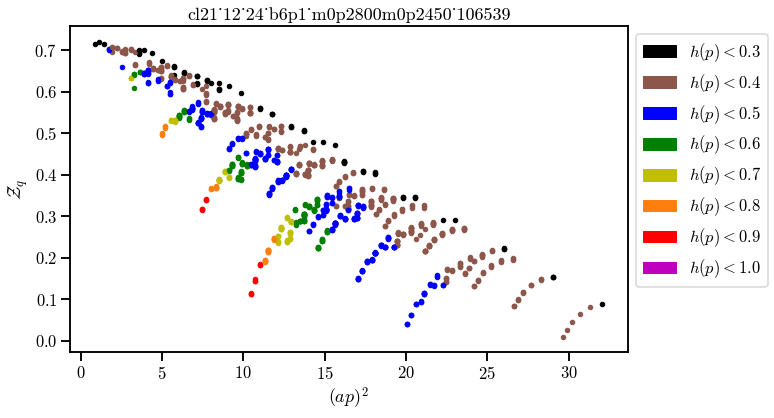

In [6]:
plot_h4_breaking(apsq_list12, Zq_12_heavy_mu, Zq_12_heavy_sigma, '$\mathcal{Z}_q$', color_list12, \
                 title = 'cl21_12_24_b6p1_m0p2800m0p2450_106539')

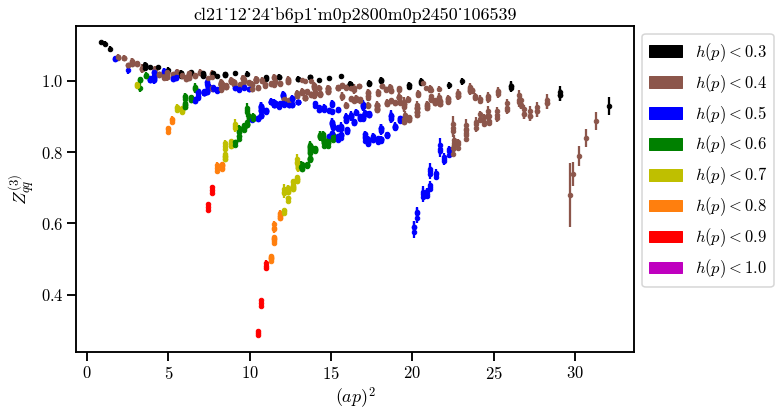

In [7]:
plot_h4_breaking(apsq_list12, Zqq_mix_12_heavy_mu[0], Zqq_mix_12_heavy_sigma[0], '$Z_{qq}^{(3)}$', color_list12, \
                 title = 'cl21_12_24_b6p1_m0p2800m0p2450_106539')

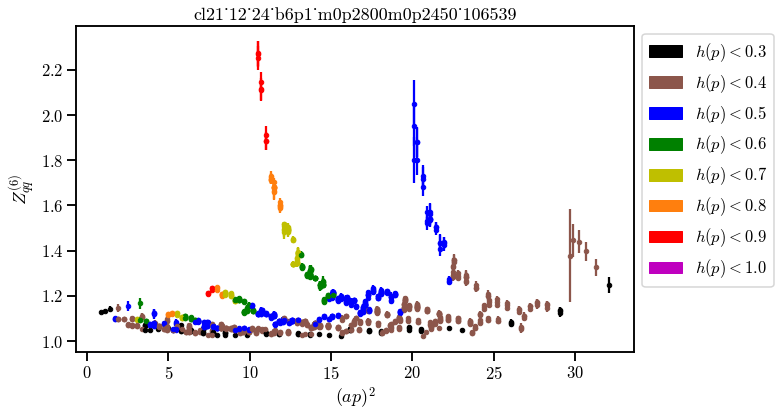

In [8]:
plot_h4_breaking(apsq_list12, Zqq_mix_12_heavy_mu[1], Zqq_mix_12_heavy_sigma[1], '$Z_{qq}^{(6)}$', color_list12, \
                 title = 'cl21_12_24_b6p1_m0p2800m0p2450_106539')

$a = 0.1167\;\mathrm{fm}$

### Ensemble cl21_12_24_b6p3_m0p2416m0p2050-b_113030

In [9]:
file12_light = '/Users/theoares/Dropbox (MIT)/research/gq_mixing/analysis_output/Zqq_113030.h5'

f12_light = h5py.File(file12_light, 'r')
print('Ran on ' + str(f12_light['cfgnum'][()]) + ' cfgs.')
Zq_12_light = np.real(f12_light['Zq'][()])
Zqq_mix_12_light = f12_light['Zqq_mix'][()]
f12_light.close()

Ran on 64 cfgs.


In [10]:
# ensemble-specific input
Zq_12_light_mu = np.mean(Zq_12_light, axis = 1)
Zq_12_light_sigma = np.std(Zq_12_light, axis = 1, ddof = 1)
Zqq_mix_12_light_mu = np.mean(np.real(Zqq_mix_12_light), axis = 2)
Zqq_mix_12_light_sigma = np.std(np.real(Zqq_mix_12_light), axis = 2, ddof = 1)

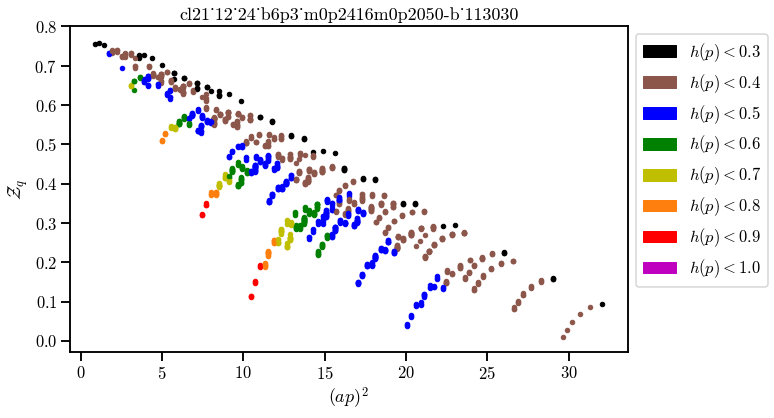

In [11]:
plot_h4_breaking(apsq_list12, Zq_12_light_mu, Zq_12_light_sigma, '$\mathcal{Z}_q$', color_list12, \
                 title = 'cl21_12_24_b6p3_m0p2416m0p2050-b_113030')

In [ ]:
plot_h4_breaking(apsq_list12, Zqq_mix_12_light_mu[0], Zqq_mix_12_light_sigma[0], '$Z_{qq}^{(3)}$', color_list12, \
                 title = 'cl21_12_24_b6p3_m0p2416m0p2050-b_113030')

In [ ]:
plot_h4_breaking(apsq_list12, Zqq_mix_12_light_mu[1], Zqq_mix_12_light_sigma[1], '$Z_{qq}^{(6)}$', color_list12, \
                 title = 'cl21_12_24_b6p3_m0p2416m0p2050-b_113030')

### Ensemble cl21_16_16_b6p3_m0p2416m0p2050-a_113356

In [ ]:
l16, t16 = 16, 16
file_16 = '/Users/theoares/Dropbox (MIT)/research/gq_mixing/analysis_output/Zqq_113356.h5'

Lat16 = Lattice(l16, t16)
f16 = h5py.File(file_16, 'r')
print('Ran on ' + str(f16['cfgnum'][()]) + ' cfgs.')
k_list16 = f16['momenta'][()]
Zq_16 = np.real(f16['Zq'][()])
Zqq_mix_16 = f16['Zqq_mix'][()]
f16.close()

In [ ]:
# Geometry-specific input for 12^3 x 24
kidx = 0
k_subset_idxs16 = []
for k in k_list16:
    # if True:
    # if k[0] < 5 and k[1] < 5 and k[2] < 5 and k[3] < 5:
    if k[0] < Lat16.L // 2 and k[1] < Lat16.L // 2 and k[2] < Lat16.L // 2 and k[3] < Lat16.L // 2:
        k_subset_idxs16.append(kidx)
    kidx += 1
k_subset_idxs16 = np.array(k_subset_idxs16)

# only use k if it's less than L / 2 in each component
# k_list = k_list[k_subset_idxs]
p_list16 = np.array([Lat16.to_linear_momentum(k) for k in k_list16])
plat_list16 = np.array([Lat16.to_lattice_momentum(k) for k in k_list16])
apsq_list16 = np.real(np.array([square(p) for p in p_list16]))

k_list_sub16 = k_list16[k_subset_idxs16]
p_list_sub16 = p_list16[k_subset_idxs16]
plat_list_sub16 = plat_list16[k_subset_idxs16]
apsq_list_sub16 = apsq_list16[k_subset_idxs16]

hp_list16 = np.real(np.array([h(p) for p in p_list16]))
hp_list_sub16 = hp_list16[k_subset_idxs16]
color_list16 = [color_fn(hp) for hp in hp_list16]
color_list_sub16 = [color_fn(hp) for hp in hp_list_sub16]

In [ ]:
# ensemble-specific input
Zq_16_mu = np.mean(Zq_16, axis = 1)
Zq_16_sigma = np.std(Zq_16, axis = 1, ddof = 1)
Zqq_mix_16_mu = np.mean(np.real(Zqq_mix_16), axis = 2)
Zqq_mix_16_sigma = np.std(np.real(Zqq_mix_16), axis = 2, ddof = 1)

In [ ]:
plot_h4_breaking(apsq_list16, Zq_16_mu, Zq_16_sigma, '$\mathcal{Z}_q$', color_list16, \
                 title = 'cl21_16_16_b6p3_m0p2416m0p2050-a_113356')

In [ ]:
plot_h4_breaking(apsq_list16, Zqq_mix_16_mu[0], Zqq_mix_16_sigma[0], '$Z_{qq}^{(3)}$', color_list16, \
                 title = 'cl21_16_16_b6p3_m0p2416m0p2050-a_113356')

In [ ]:
plot_h4_breaking(apsq_list16, Zqq_mix_16_mu[1], Zqq_mix_16_sigma[1], '$Z_{qq}^{(6)}$', color_list16, \
                 title = 'cl21_16_16_b6p3_m0p2416m0p2050-a_113356')

# Convert to $\overline{\mathrm{MS}}$